In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import pickle
from statistics import mean
import os

import census
import janitor
from census import Census
import us
from us import states

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


import contextily as ctx
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
pwd

'C:\\Users\\Lahiri\\Gentrification\\Predicting-Gentrification-in-DC\\Unsup and Sup learning'

### Calling cleaned dataset

In [3]:
acs_9yr_imputed = pd.read_hdf('../acs_pre_clustering.h5', 'acs')

In [4]:
acs_9yr_imputed

Year state   tract  tot_pop  prop_black  prop_nwhite  prop_bach  \
0     2012    11  006500   2591.0    0.049016     0.111926   0.804450   
1     2012    11  007100   3267.0    0.649219     0.697888   0.411297   
2     2012    11  007708   2704.0    0.991124     0.991124   0.115286   
3     2012    11  007807   2271.0    0.994716     0.998239   0.044529   
4     2012    11  008402   2157.0    0.407974     0.440890   0.579410   
...    ...   ...     ...      ...         ...          ...        ...   
1836  2021    11  010900   3634.0    0.858558     0.983214   0.138844   
1837  2021    11  011001   2385.0    0.331656     0.404612   0.705603   
1838  2021    11  011002   1519.0    0.157999     0.290323   0.757268   
1839  2021    11  011100   5192.0    0.692797     0.848613   0.369585   
1840  2021    11  980000     17.0    0.000597     0.053674   1.000000   

      pcap_inc_overall     pcap_inc_w    pcap_inc_b  prop_long_res  perc_fem  \
0         92688.586667   98046.417778  39747.493333       0.380671  0.530297   
1         38256.711111   80668.933333  16444.711111       0.249150  0.574227   
2         21951.502222   42440.087061  21413.591111       0.381662  0.567308   
3         17242.711111   38537.713678  17222.613333       0.333185  0.560546   
4         51624.097778   72238.506667  23970.737778       0.276044  0.576263   
...                ...            ...           ...            ...       ...   
1836      21977.000000    4849.000000  21205.000000       0.355319  0.455146   
1837      73420.000000   75321.000000  78489.000000       0.555975  0.535430   
1838     106678.000000  111423.000000  62535.000000       0.444520  0.541145   
1839      39253.000000   71305.000000  33927.000000       0.744508  0.471109   
1840      32755.647925   55831.348915   1843.578947       0.010632  0.068498   

      perc_young_pop    median_hous  median_rent  
0           0.379390  860303.111111  1756.782222  
1           0.341598  486366.222222   468.160000  
2           0.187500  238808.888889  1029.715556  
3           0.195068  237390.222222   998.977778  
4           0.389893  663699.555556  1423.395556  
...              ...            ...          ...  
1836        0.407815  318600.000000  1248.000000  
1837        0.394549  398400.000000  1960.000000  
1838        0.212640  407500.000000  1832.000000  
1839        0.217065  553600.000000  1386.924535  
1840        1.000000  357485.985899  1220.377433  

[1841 rows x 15 columns]

### Subsetting for 2012 and 2021 data

In [5]:
proper_tracts = pd.DataFrame(acs_9yr_imputed.tract.value_counts()) #proper tracts are the ones for whom we have 10 years of data
proper_tracts_list =  proper_tracts[proper_tracts.tract == 10].reset_index()['index'].unique().tolist() 

#subset for 'proper tracts'
acs_9yr_cluster = acs_9yr_imputed[(acs_9yr_imputed.tract.isin(proper_tracts_list))]

#subset for years between which we are looking at change in variables
acs_9yr_cluster = acs_9yr_cluster[(acs_9yr_cluster.Year == 2012) | (acs_9yr_cluster.Year == 2021)]

### Pivoting to calculate % changes for each variable

In [6]:
acs_9yr_cluster_wide = acs_9yr_cluster.pivot_wider(
    index = 'tract', 
    names_from = 'Year', 
    values_from = ['tot_pop',
                  'prop_black',
                  'prop_nwhite', 
                  'prop_bach',
                  'pcap_inc_overall',
                  'pcap_inc_w',
                  'pcap_inc_b',
                  'perc_fem',
                  'perc_young_pop',
                   'prop_long_res',
                  'median_hous',
                  'median_rent'],
    names_glue = "{_value}_{Year}"
  )


In [7]:
for i in list(acs_9yr_cluster.iloc[:,4:].columns):
    acs_9yr_cluster_wide['perc_change_'+str(i)] = (acs_9yr_cluster_wide[str(i)+ '_'+str(2021)]-acs_9yr_cluster_wide[str(i)+ '_'+str(2012)])/acs_9yr_cluster_wide[str(i)+ '_' + str(2012)]
    
acs_final = acs_9yr_cluster_wide[[col for col in acs_9yr_cluster_wide.columns if 'perc_change' in col or 'tract' in col]]
acs_final.drop(21, inplace = True)
cluster_features = acs_final[['perc_change_prop_nwhite','perc_change_prop_bach', 
              'perc_change_pcap_inc_overall', 
              'perc_change_median_hous','perc_change_median_rent']]    

### Hierarchical Clustering

In [8]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(cluster_features)

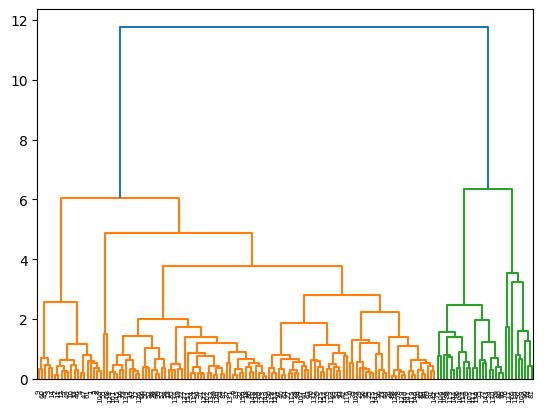

In [9]:
dendrogram = sch.dendrogram(sch.linkage(cluster_features, method = 'ward'))

In [10]:
g= globals()
cluster_df= pd.DataFrame(cluster_features)
cluster_df = cluster_df.rename(columns = {0:'perc_change_prop_nwhite',1:'perc_change_prop_bach', 2:
              'perc_change_pcap_inc_overall',3:'perc_change_median_hous',4:'perc_change_median_rent'})

## Mean of variables for each cluster
for i in range(0,4):
    varname = 'cluster_{}'.format(i)
    g[varname] = pd.DataFrame(cluster_df[labels == i].mean()).rename(columns = {0:'mean'}).reset_index()

dc = pd.DataFrame(cluster_df.mean()).rename(columns = {0:'mean'}).reset_index()

In [11]:
for i in range(0,4):
    varname = 'index_{}'.format(i)
    g[varname] = cluster_df[labels == i].index.values.tolist()

#Creating new variable reflecting gentrificaition status
acs_final['label'] = np.where(acs_final.index.isin(index_0),'City Average',0)
acs_final['label'] = np.where(acs_final.index.isin(index_1),'gentrifying',acs_final['label'])
acs_final['label'] = np.where(acs_final.index.isin(index_2),'intense gentrification',acs_final['label'])
acs_final['label'] = np.where(acs_final.index.isin(index_3),'affordable',acs_final['label'])

In [12]:
acs_final.to_hdf('../acs_clustered.h5', key='acs', mode='w')

In [13]:
cluster_0['label'] = 'City Average'
cluster_1['label'] = 'gentrifying'
cluster_2['label'] = 'intense gentrification'
cluster_3['label'] = 'affordable'
dc['label'] = 'DC average'


for i in ['cluster_0','cluster_1','cluster_2','cluster_3','dc']:
    varname = i+'_wide'
    g[varname] = pd.pivot(g[i], index='index', columns = 'label', values ='mean')

plot_df = dc_wide.merge(cluster_0_wide,on='index').merge(cluster_1_wide,on='index').merge(cluster_2_wide,on='index').merge(cluster_3_wide,on='index')
plot_df = plot_df.reset_index()


In [14]:
dc
cluster_1
cluster_2

index      mean       label
0       perc_change_prop_nwhite  0.051891  DC average
1         perc_change_prop_bach  0.645882  DC average
2  perc_change_pcap_inc_overall  0.307356  DC average
3       perc_change_median_hous  0.268822  DC average
4       perc_change_median_rent  0.277249  DC average

index      mean        label
0       perc_change_prop_nwhite -0.041090  gentrifying
1         perc_change_prop_bach  3.201179  gentrifying
2  perc_change_pcap_inc_overall  0.504986  gentrifying
3       perc_change_median_hous  0.481732  gentrifying
4       perc_change_median_rent  0.259188  gentrifying

index      mean                   label
0       perc_change_prop_nwhite -0.102477  intense gentrification
1         perc_change_prop_bach  1.415764  intense gentrification
2  perc_change_pcap_inc_overall  0.604269  intense gentrification
3       perc_change_median_hous  0.531721  intense gentrification
4       perc_change_median_rent  0.361486  intense gentrification

### Visualizing results from clustering

In [15]:
# for i in ['stable','gentrifying','intense gentrification','affordable']:
helper = pd.DataFrame({'index':['% change in median home value','% change in median rent','% change in overall per capita income',
               '% change in proportion of bachelors+ degree olding population','% change in proportion of non whites']})
def plot(i): 
    fig, ax = plt.subplots()
    ax.hlines(y=range(1,len(plot_df.index)+1), xmin=plot_df['DC average'], xmax=plot_df[i],color='black')
    ax.scatter(plot_df['DC average'], range(1,len(plot_df.index)+1), color='skyblue', alpha=1, label='Citywide Change')
    ax.scatter(plot_df[i], range(1,len(plot_df.index)+1), color='red', alpha=1 , label=i)
    ax.legend()

    # Add title and axis names
    ax.set_facecolor(color = 'white')
    ax.set_yticks(range(1,len(plot_df.index)+1), helper['index'])
    ax.set_title('Comparison of DC average and ' + str(i)+' tracts', loc='left')
    ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,2.2,2.4,2.6,2.8,3,3.2])
    ax.set_xlabel('% change in variables')
    ax.set_ylabel('Metrics')
    plt.show()

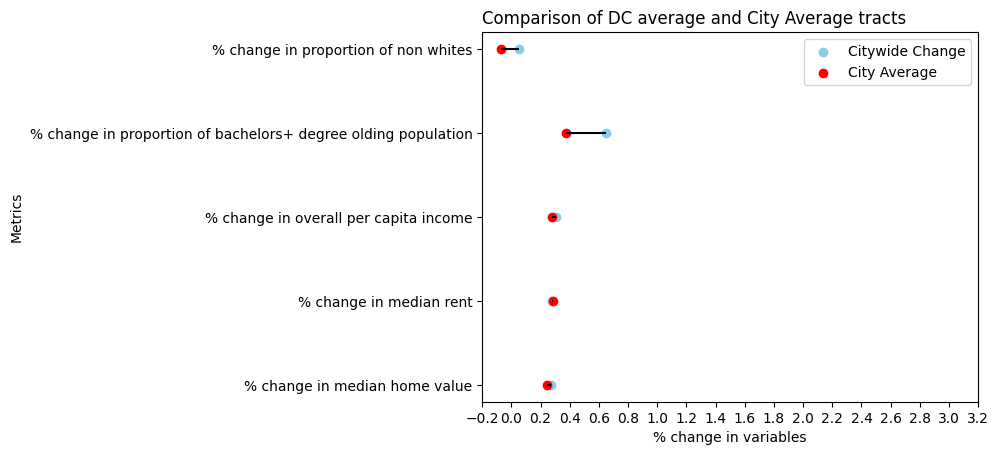

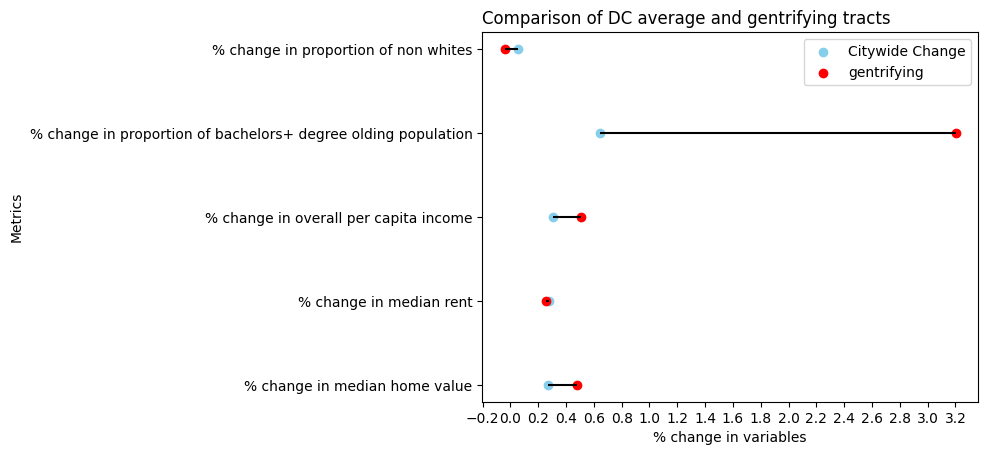

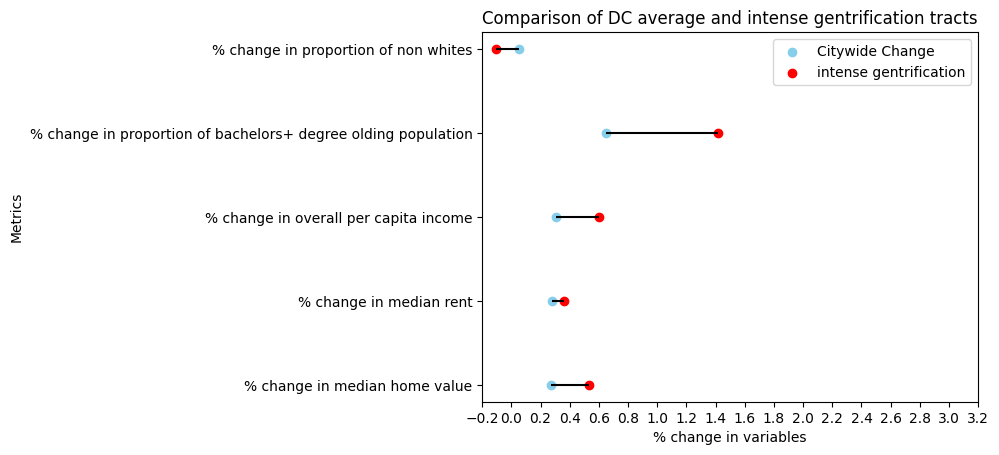

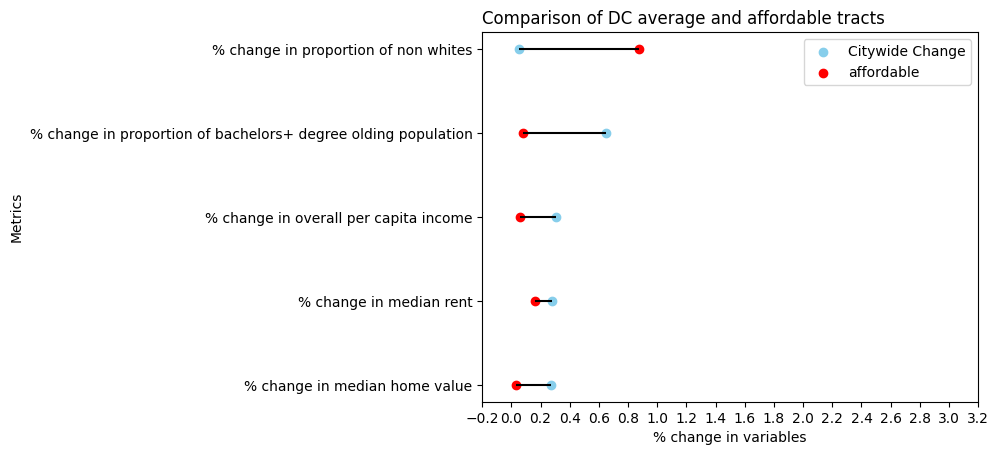

In [16]:
for x in ['City Average','gentrifying','intense gentrification','affordable']:
    plot(x)

In [17]:

plot_df['index']
helper

0         perc_change_median_hous
1         perc_change_median_rent
2    perc_change_pcap_inc_overall
3           perc_change_prop_bach
4         perc_change_prop_nwhite
Name: index, dtype: object

index
0                                  % change in median home value
1                                        % change in median rent
2                          % change in overall per capita income
3  % change in proportion of bachelors+ degree olding population
4                           % change in proportion of non whites

In [18]:
a= pd.concat([cluster_0,cluster_1,cluster_2,cluster_3])

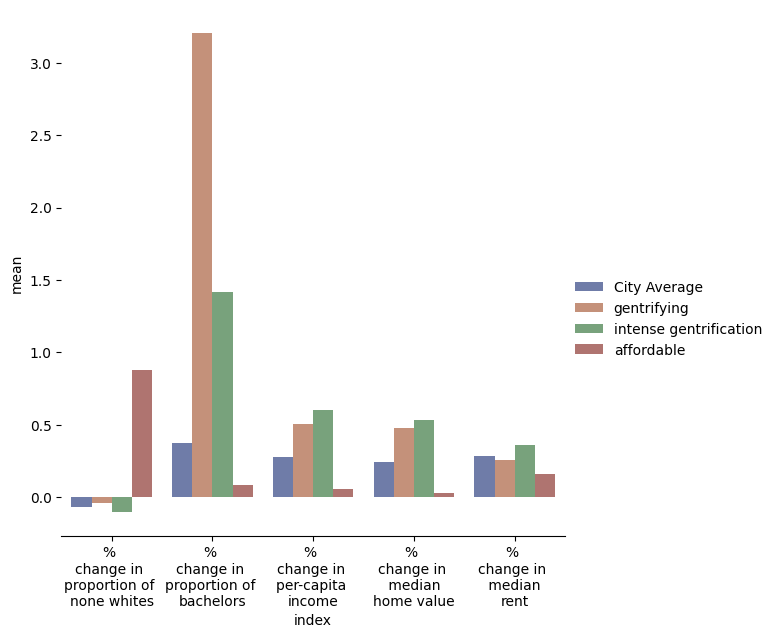

In [19]:
g = sns.catplot(
    data=a, kind="bar",
    x="index", y="mean", hue="label",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_xticklabels(['% \nchange in \nproportion of \nnone whites','% \nchange in \nproportion of \nbachelors',
           '% \nchange in \nper-capita \nincome','% \nchange in \n median \nhome value',
           '% \nchange in \n median \nrent'])
g.legend.set_title("")


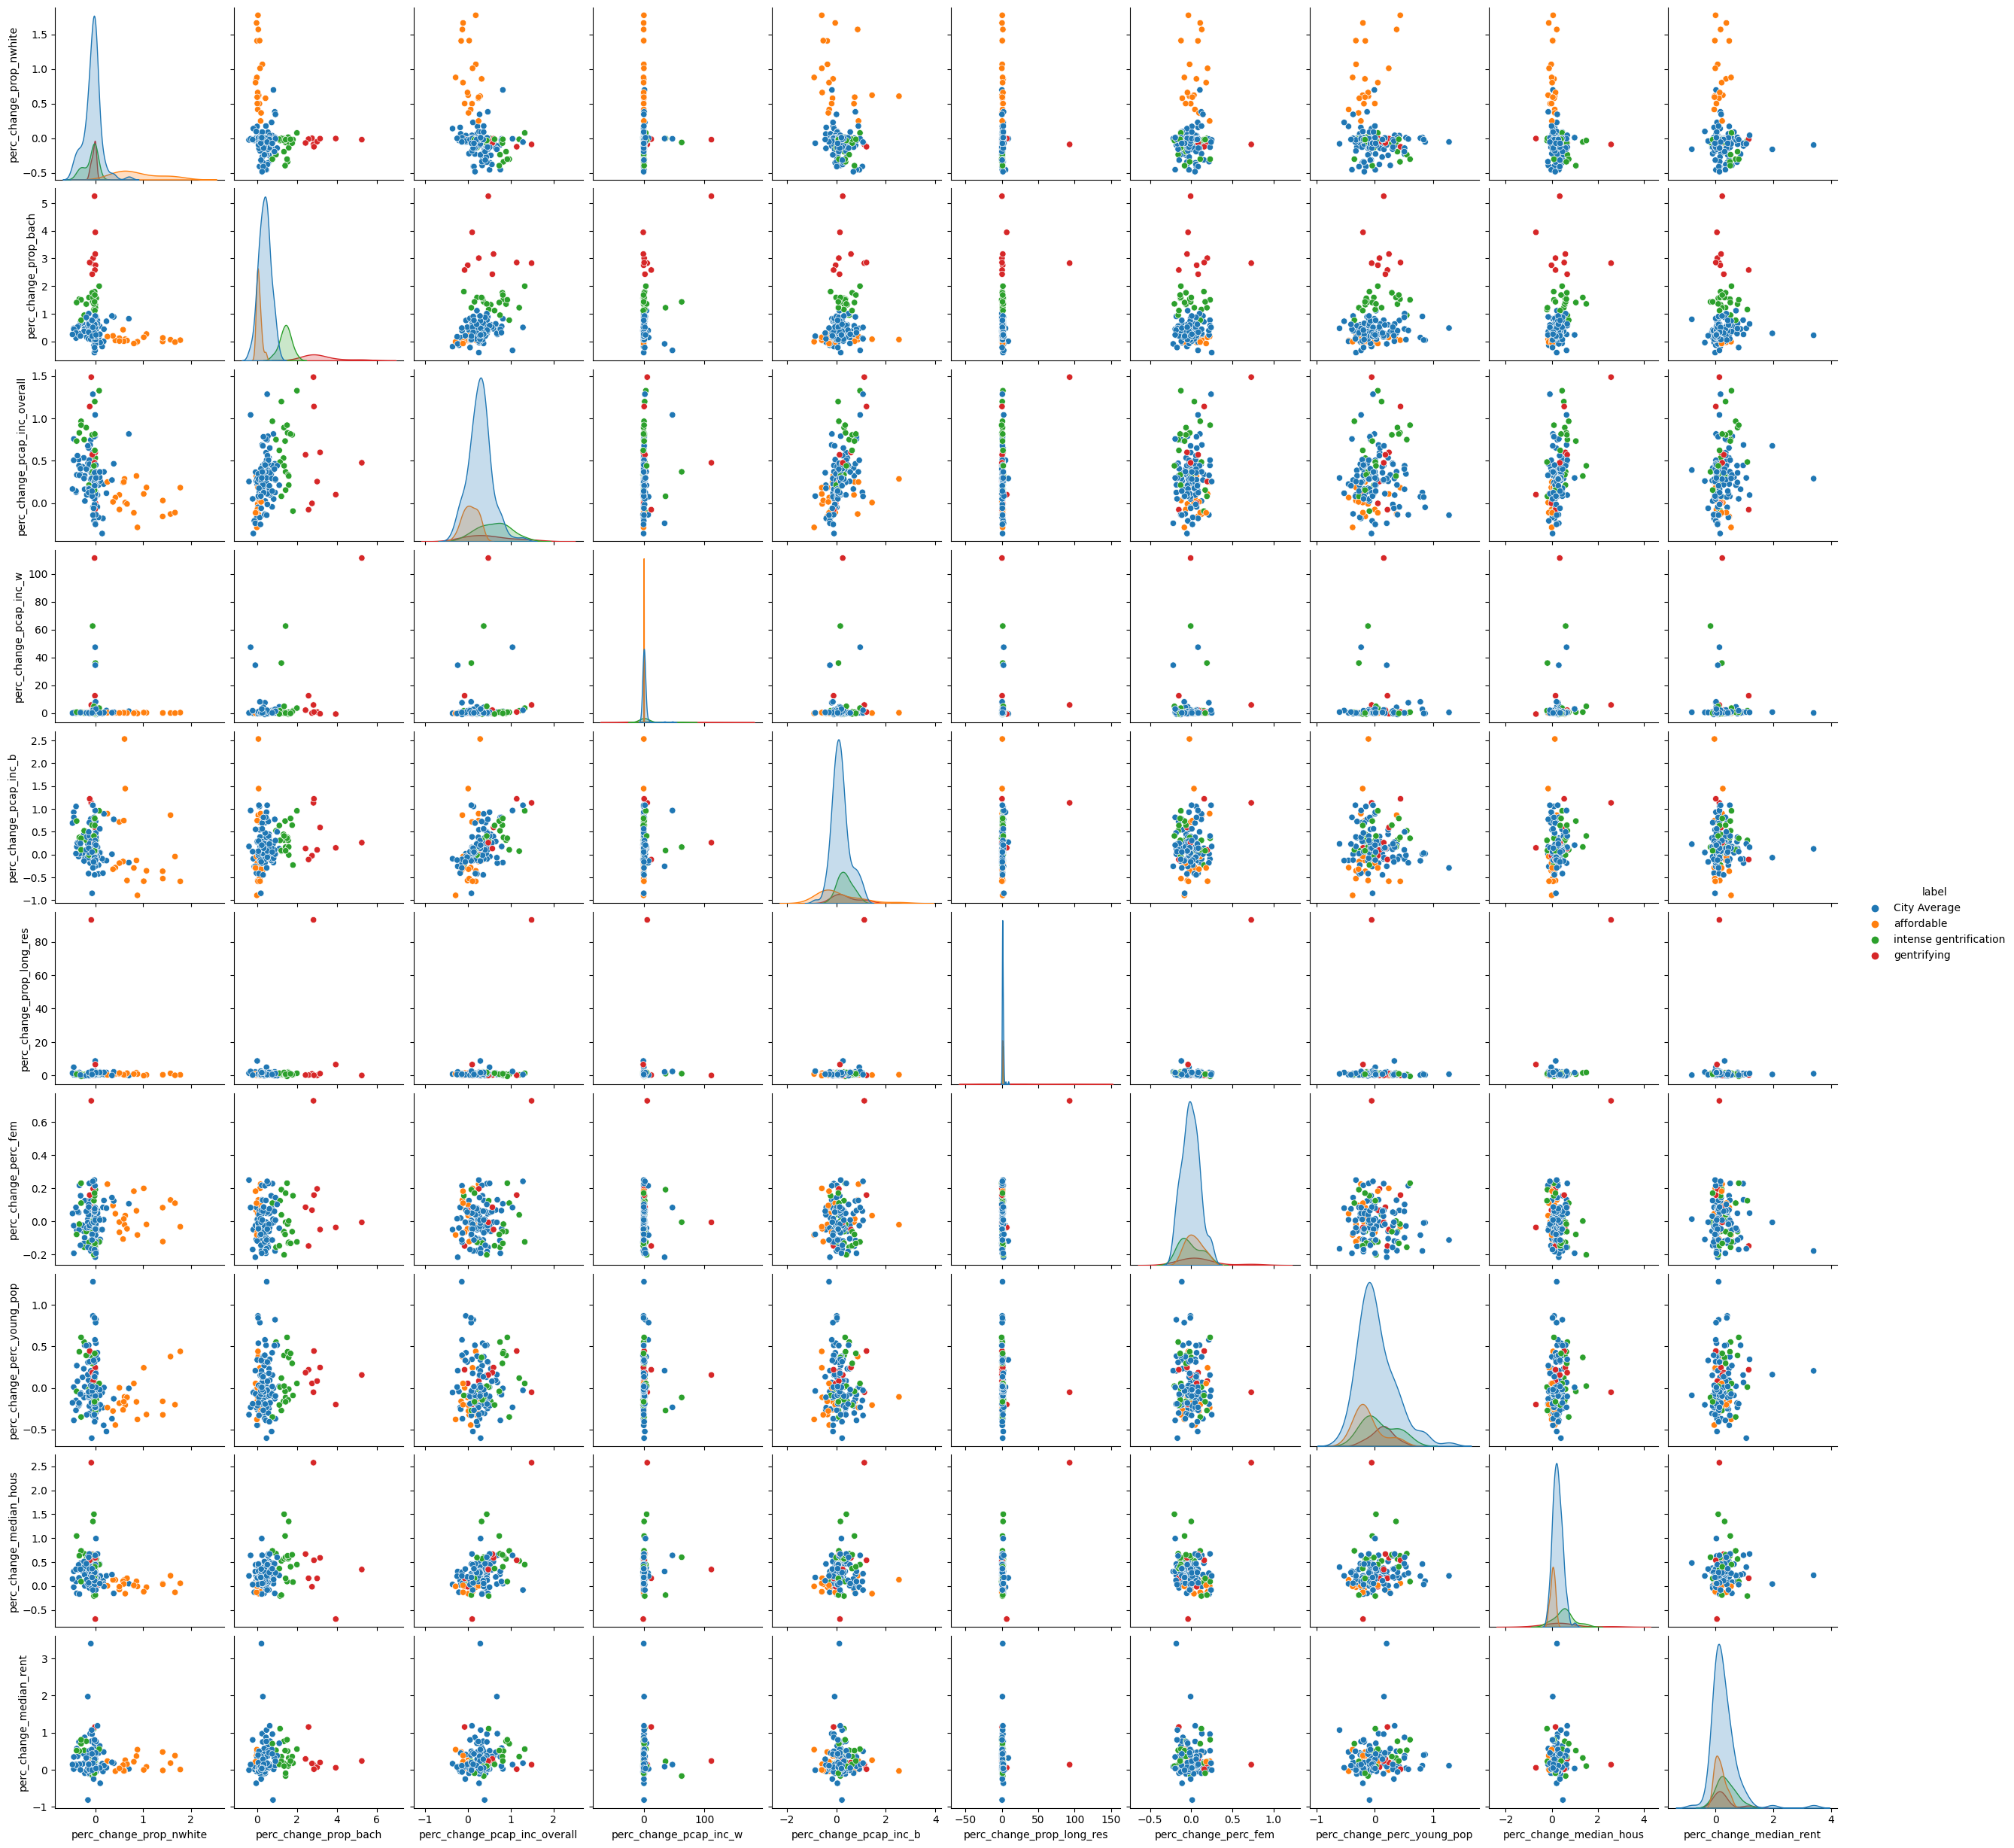

In [20]:
df = acs_final.iloc[:,2:13]
sns.pairplot(df, diag_kind='kde', hue = 'label')  

### Geo mapping by gentrification status

<AxesSubplot: >

(-8586103.193779986, -8560343.574179746, 4690409.992130087, 4722536.728137838)

Text(0.5, 1.0, 'Census Tracts in DC by gentrification status (%change 2012-2021)')

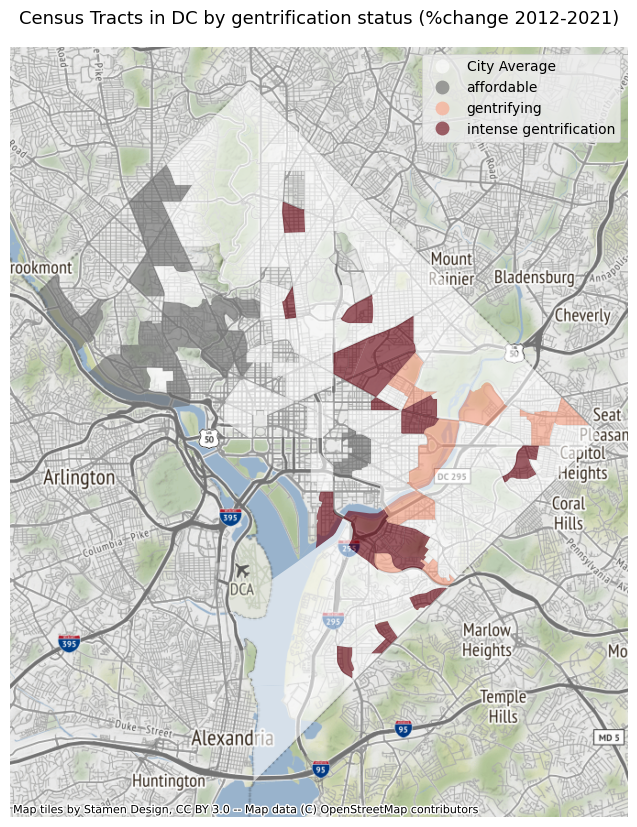

In [27]:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

top = cm.get_cmap('Greys', 128) # r means reversed version
bottom = cm.get_cmap('Reds', 128)
# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# create a new colormaps with a name of OrangeBlue
grey_red = ListedColormap(newcolors, name='OrangeBlue')

dc_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_11_tract.zip")
dc_merge = dc_tract.merge(acs_final, left_on = "TRACTCE", right_on = 'tract', how = 'right')
dc_merge_base = dc_merge.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))

colors = {'stable': 'white',
               'affordable': 'grey',
               'intense gentrification': 'purple',
               'gentrifying': 'pink'}
dc_merge_base.plot(column = "label",
                   ax = ax,
                   cmap = grey_red,
                   alpha=0.6,
                   legend = True)

plt.style.use('bmh')
ax.axis('off')

ax.set_title('Census Tracts in DC by gentrification status (%change 2012-2021)',fontsize=13)
# plt.legend(labels = colors.keys(),
#            loc = 'upper right',
#            ncol = 1,
#           frameon = False,)
ctx.add_basemap(ax, zorder = 0)

<AxesSubplot: >

(-8586103.193779986, -8560343.574179746, 4690409.992130087, 4722536.728137838)

Text(0.5, 1.0, 'Census Tracts in DC by % of Black population 2021 ')

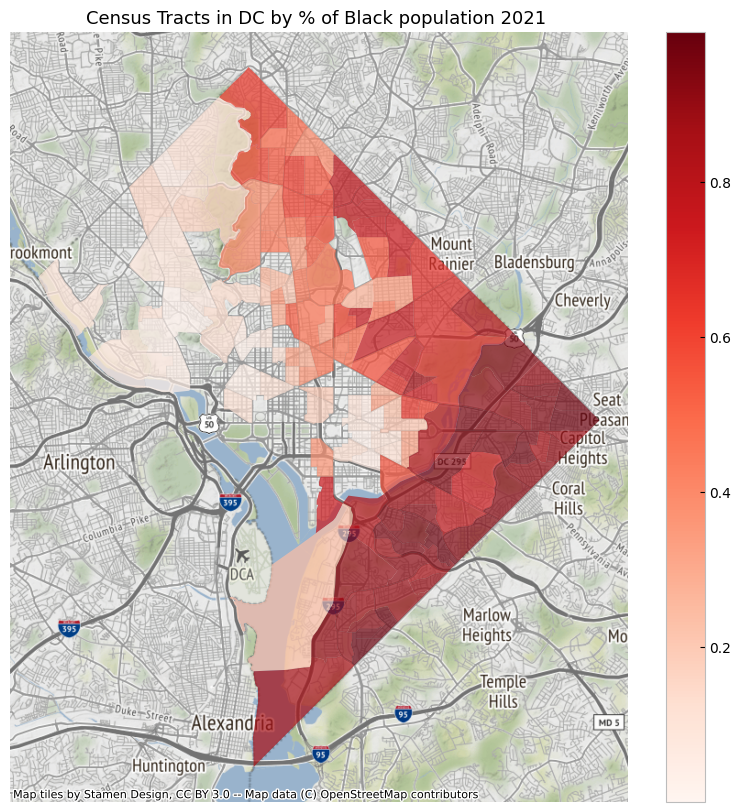

In [31]:
dc_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_11_tract.zip")
dc_merge = dc_tract.merge(acs_9yr_imputed[acs_9yr_imputed.Year == 2021], left_on = "TRACTCE", right_on = 'tract', how = 'right')
dc_merge_base = dc_merge.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
dc_merge_base.plot(column = "prop_black",
                       ax = ax,
                       cmap = 'Reds',
                    alpha=0.7,
                       legend = True)
plt.style.use('bmh')
ax.axis('off')

ax.set_title('Census Tracts in DC by % of Black population 2021 ',fontsize=13)

ctx.add_basemap(ax)